In [1]:
import os
import sys 
sys.path.insert(0, '/home/aiwenxu/2022-xu-retinal-degeneration')

**Phase 3 death FI curve (injected current)**

In [2]:
from model.retinasim_phase3.simulation_fi import fi_curve_simulation
from model.retinasim_phase3.simulation_utils import SimulationParam
import pulse2percept as p2p
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
for cell_percent in [100, 70, 40, 10]:

    sp_txt = "../model/parameter/cottaris_original_2hz.txt"
    sp = SimulationParam(sp_txt)

    sp.xy_coord_folder = "../model/layout_phase3/dendritic-tree-coordinate-{}".format(cell_percent)
    sp.z_coord_folder = "../model/layout_phase3/z-coordinate-{}".format(cell_percent)
    sp.cone_exists = False
    sp.imped = 1000

    time_in_ms = 1200
    select_GPU = 0
    genn_directory = "GeNNworkspace_{}".format(select_GPU)
    pre_computed_weights_folder = "../model/weights_phase3"
    
    NUM_GL_ON = np.load("../model/layout_phase3/z-coordinate-{}/GL_ON.npy".format(cell_percent)).shape[1]
    NUM_GL_OFF = np.load("../model/layout_phase3/z-coordinate-{}/GL_OFF.npy".format(cell_percent)).shape[1]

    res_on = []
    res_off = []

    injected_currents = np.arange(0, 5, 0.1)
    
    save_folder = "../data/fig8/phase3_death_injected"
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for cur_val in injected_currents:
        estim = p2p.stimuli.MonophasicPulse(-cur_val, 1000, stim_dur=1200, delay_dur=200)
        ic_ta_on = TimedArray(np.transpose(np.array([estim[0,::1][0] for i in range(NUM_GL_ON)])), dt=1*ms)
        ic_ta_off = TimedArray(np.transpose(np.array([estim[0,::1][0] for i in range(NUM_GL_OFF)])), dt=1*ms)
        data = fi_curve_simulation(time_in_ms, sp, ic_ta_on, ic_ta_off, pre_computed_weights_folder, select_GPU=select_GPU, genn_directory=genn_directory)
        _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = data
        res_on.append([np.count_nonzero(spikes_gl_on['t'][k]>200*ms) for k in spikes_gl_on['t'].keys()])
        res_off.append([np.count_nonzero(spikes_gl_off['t'][k]>200*ms) for k in spikes_gl_off['t'].keys()])
        print("amp {} done".format(cur_val))

        res_on_np = np.array(res_on)
        res_off_np = np.array(res_off)

        np.save("{}/res_on_{}.npy".format(save_folder, cell_percent), res_on_np)
        np.save("{}/res_off_{}.npy".format(save_folder, cell_percent), res_off_np)

running brian code generation ...
building genn executable ...
['/home/aiwenxu/genn/bin/genn-buildmodel.sh', '-i', '/home/aiwenxu/2022-xu-retinal-degeneration/figures:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_0:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_0/brianlib/randomkit', 'magicnetwork_model.cpp']
executing genn binary on GPU ...
simulation time: 91.31613779067993
amp 0.0 done
running brian code generation ...
building genn executable ...
['/home/aiwenxu/genn/bin/genn-buildmodel.sh', '-i', '/home/aiwenxu/2022-xu-retinal-degeneration/figures:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_0:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_0/brianlib/randomkit', 'magicnetwork_model.cpp']
executing genn binary on GPU ...
simulation time: 89.21904945373535
amp 0.1 done
running brian code generation ...
building genn executable ...
['/home/aiwenxu/genn/bin/genn-buildmodel.sh', '-i', '/home/aiwenxu/2022-xu-reti

Text(0.5, 1.0, 'OFF RGC')

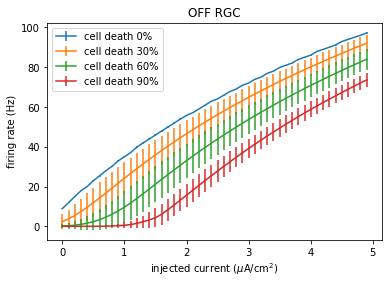

In [6]:
cell_type = "off"
for cp in [100, 70, 40, 10]:
    res = np.load("../data/fig8/phase3_death_injected/res_{}_{}.npy".format(cell_type, cp))
    _ = plt.errorbar(np.arange(0, 5, 0.1), np.mean(res, axis=1), yerr=np.std(res, axis=1), label="cell death {}%".format(100-cp))
plt.legend()
plt.xlabel("injected current ($\mu$A/cm$^2$)")
plt.ylabel("firing rate (Hz)")
plt.title("OFF RGC")

Text(0.5, 1.0, 'ON RGC')

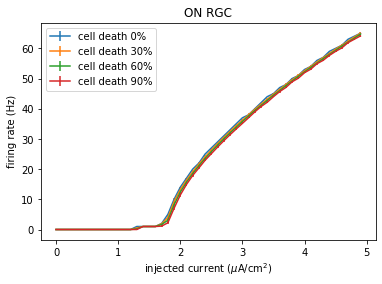

In [7]:
cell_type = "on"
for cp in [100, 70, 40, 10]:
    res = np.load("../data/fig8/phase3_death_injected/res_{}_{}.npy".format(cell_type, cp))
    _ = plt.errorbar(np.arange(0, 5, 0.1), np.mean(res, axis=1), yerr=np.std(res, axis=1), label="cell death {}%".format(100-cp))
plt.legend()
plt.xlabel("injected current ($\mu$A/cm$^2$)")
plt.ylabel("firing rate (Hz)")
plt.title("ON RGC")

**Phase 1/2 FI curve (epiretinal)**

In [ ]:
import numpy as np
from model.retinasim_phase3.simulation import estim_to_retina_output
from model.retinasim_phase3.simulation_utils import SimulationParam
import pickle
from brian2 import *
import os
import pulse2percept as p2p

In [4]:
pre_computed_weights_folder = "../model/weights_phase3"
implant_mode = "epiretinal"

for cell_percent in [100, 70, 40, 10]:

    sp_txt = "../model/parameter/cottaris_original_2hz.txt"
    sp = SimulationParam(sp_txt)

    sp.xy_coord_folder = "../model/layout_phase3/dendritic-tree-coordinate-{}".format(cell_percent)
    sp.z_coord_folder = "../model/layout_phase3/z-coordinate-{}".format(cell_percent)
    sp.cone_exists = False
    sp.imped = 1000

    # subretinal stimulation
    if implant_mode == "subretinal":
        sp.implant_mode = "subretinal"
        sp.electrode_z = 135

    res_on = []
    res_off = []

    injected_currents = np.arange(0, 5, 0.1)

    data_folder = "../data/fig8/phase3_death_epiretinal"
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    for cur_val in injected_currents:
        estim = p2p.stimuli.MonophasicPulse(-cur_val, 1000, stim_dur=1200, delay_dur=200)

        time_in_ms = 1200
        select_GPU = 1
        genn_directory = "GeNNworkspace_{}".format(select_GPU)
        _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, estim, pre_computed_weights_folder, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), dt=0.1, select_GPU=select_GPU, genn_directory=genn_directory)
        res_on.append([np.count_nonzero(spikes_gl_on['t'][k]>200*ms) for k in range(len(spikes_gl_on['t'].keys()))])
        res_off.append([np.count_nonzero(spikes_gl_off['t'][k]>200*ms) for k in range(len(spikes_gl_off['t'].keys()))])
        print("amp {} done".format(cur_val))

        res_on_np = np.array(res_on)
        res_off_np = np.array(res_off)

        np.save("{}/res_on_{}.npy".format(data_folder, cell_percent), res_on_np)
        np.save("{}/res_off_{}.npy".format(data_folder, cell_percent), res_off_np)

In [8]:
def calculate_mean_std_center(res, cell_type):
    center = []
    res = np.transpose(res)
    x, y = np.load("../model/layout_phase3/dendritic-tree-coordinate-100/GL_{}.npy".format(cell_type.upper()))
    for key in range(res.shape[0]):
        if np.sqrt(np.square(x[key]) + np.square(y[key])) <= 40:
            center.append(res[key])
    center = np.array(center)
    return np.mean(center, axis=0), np.std(center, axis=0)

Text(0.5, 1.0, 'OFF RGC')

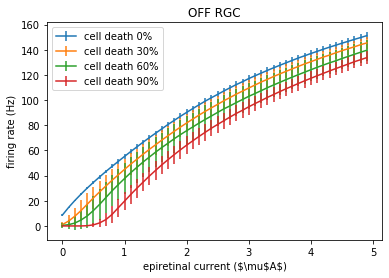

In [11]:
cell_type = "off"
for cp in [100, 70, 40, 10]:
    res = np.load("../data/fig8/phase3_death_epiretinal/res_{}_{}.npy".format(cell_type, cp))
    mean, std = calculate_mean_std_center(res, "off")
    _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="cell death {}%".format(100-cp))
plt.legend()
plt.xlabel("epiretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("OFF RGC")

Text(0.5, 1.0, 'ON RGC')

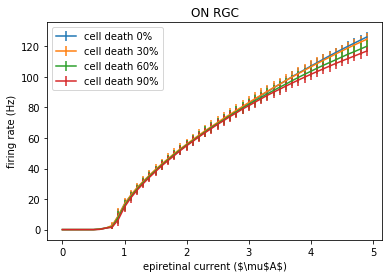

In [12]:
cell_type = "on"
for cp in [100, 70, 40, 10]:
    res = np.load("../data/fig8/phase3_death_epiretinal/res_{}_{}.npy".format(cell_type, cp))
    mean, std = calculate_mean_std_center(res, "off")
    _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="cell death {}%".format(100-cp))
plt.legend()
plt.xlabel("epiretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("ON RGC")

**Phase 1/2 FI curve (subretinal)**

In [ ]:
pre_computed_weights_folder = "../model/weights_phase3"
implant_mode = "subretinal"

for cell_percent in [100, 70, 40, 10]:

    sp_txt = "../model/parameter/cottaris_original_2hz.txt"
    sp = SimulationParam(sp_txt)

    sp.xy_coord_folder = "../model/layout_phase3/dendritic-tree-coordinate-{}".format(cell_percent)
    sp.z_coord_folder = "../model/layout_phase3/z-coordinate-{}".format(cell_percent)
    sp.cone_exists = False
    sp.imped = 1000

    # subretinal stimulation
    if implant_mode == "subretinal":
        sp.implant_mode = "subretinal"
        sp.electrode_z = 135

    res_on = []
    res_off = []

    injected_currents = np.arange(0, 5, 0.1)

    data_folder = "../data/fig8/phase3_death_epiretinal"
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    for cur_val in injected_currents:
        estim = p2p.stimuli.MonophasicPulse(-cur_val, 1000, stim_dur=1200, delay_dur=200)

        time_in_ms = 1200
        select_GPU = 1
        genn_directory = "GeNNworkspace_{}".format(select_GPU)
        _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, estim, pre_computed_weights_folder, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), dt=0.1, select_GPU=select_GPU, genn_directory=genn_directory)
        res_on.append([np.count_nonzero(spikes_gl_on['t'][k]>200*ms) for k in range(len(spikes_gl_on['t'].keys()))])
        res_off.append([np.count_nonzero(spikes_gl_off['t'][k]>200*ms) for k in range(len(spikes_gl_off['t'].keys()))])
        print("amp {} done".format(cur_val))

        res_on_np = np.array(res_on)
        res_off_np = np.array(res_off)

        np.save("{}/res_on_{}.npy".format(data_folder, cell_percent), res_on_np)
        np.save("{}/res_off_{}.npy".format(data_folder, cell_percent), res_off_np)

Text(0.5, 1.0, 'OFF RGC')

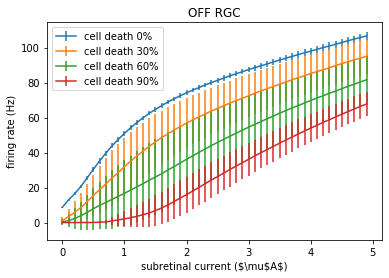

In [13]:
cell_type = "off"
for cp in [100, 70, 40, 10]:
    res = np.load("../data/fig8/phase3_death_subretinal/res_{}_{}.npy".format(cell_type, cp))
    mean, std = calculate_mean_std_center(res, "off")
    _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="cell death {}%".format(100-cp))
plt.legend()
plt.xlabel("subretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("OFF RGC")

Text(0.5, 1.0, 'ON RGC')

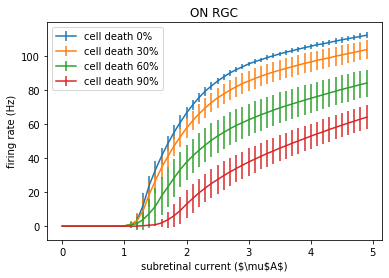

In [16]:
cell_type = "on"
for cp in [100, 70, 40, 10]:
    res = np.load("../data/fig8/phase3_death_subretinal/res_{}_{}.npy".format(cell_type, cp))
    mean, std = calculate_mean_std_center(res, "off")
    # remove one data point due to numerical errors
    if cp == 100:
        mean[32] = 97.67567567567568
        std[32] = 1.2314362972858939
    _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="cell death {}%".format(100-cp))
plt.legend()
plt.xlabel("subretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("ON RGC")